In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np, keras, bcolz, re
from keras_tqdm import TQDMNotebookCallback
from keras.applications import VGG16
from keras.models import Model
from keras.metrics import mse
import keras.layers as l
import keras.backend as K

Using TensorFlow backend.


# Neural Super Resolution

In this notebook, we are going to explore the awesomeness that is super resolution. We can in essence "zoom, ENHANCE!" with amazing accuracy, as you'll come to find out in the notebook.

In [2]:
path = '/data/imagenet/sample/'; sample = True
#path = '/data/imagenet/full/'; sample = False

First off, we will create bcolz objects which contain the resized images for imagenet. We have 288x288 images, resized to 72x72 in two seperate arrays. If it's the sample, it can be read into memory. Otherwise, keep as bcolz object

In [3]:
arr_lr = bcolz.open(f'{path}trn_resized_72.bc')
arr_hr = bcolz.open(f'{path}trn_resized_288.bc')
if sample: arr_lr, arr_hr = arr_lr[:], arr_hr[:]

In [4]:
lr_shape, hr_shape = arr_lr.shape, arr_hr.shape

We are going to train a fully conv net to output a higher resolution through a technique called upsampling.

First, we'll build a conv block. This is simply a Conv2D layer, followed by bn and a relu activation.

In [5]:
def conv_block(x, filters, k_size, strides=(1,1), padding='same', act='relu'):
    x = l.Conv2D(filters, k_size, strides=strides, padding=padding, activation=act)(x)
    return l.BatchNormalization()(x)

In [6]:
def res_block(inp, filters=64, k_size=(3,3)):
    x = conv_block(inp, filters, k_size)
    x = conv_block(x, filters, k_size, act=None)
    return l.add([inp, x])

In [7]:
def up_block(x):
    x = l.UpSampling2D()(x)
    x = l.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    return l.BatchNormalization()(x)

In [8]:
def get_model(arr):
    inp = l.Input(arr.shape[1:])
    x = conv_block(inp, 64, (9,9))
    for i in range(4): x = res_block(x)
    for i in range(2): x = up_block(x)
    x = l.Conv2D(3, (9,9), activation='tanh', padding='same')(x)
    outp = l.Lambda(lambda x: (x + 1) * 127.5)(x)
    return inp, outp

In [9]:
inp, outp = get_model(arr_lr)
lr_model = Model([inp],[outp])

So 'lr_model' is going to take in the low resolution image, go through some fully convolutional layers (resnet-esque), and spit out an image 4x the pixel density. By going through 2 UpSampling layers, we'll have changed from 72x72 to 288x288, the same resolution as our high-res images.

Now, we have to decide how exactly to we're going to compute the loss function. We could use pure pixel values, but Perceptual loss, or comparing the mean squared difference between Conv layers as done in [style transfer](https://github.com/Corbin-A/style_transfer), [has been found to work even better](https://arxiv.org/pdf/1603.08155.pdf).

So we're going to use different conv layers from VGG16 and compare the outputs different conv layers of:
1. the original high res image is passed through VGG16
2. the output of the above, 'lr_model' model

It's very important to make sure that we don't train these layers, as it is our loss function.

In [10]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [11]:
vgg_input = l.Input(hr_shape[1:])
vgg_base = VGG16(include_top=False, input_tensor=l.Lambda(preproc)(vgg_input))
for lyr in vgg_base.layers: lyr.trainable = False

In [12]:
get_outps = lambda m, n: m.get_layer(f'block{n}_conv1').output 
vgg_content = Model(vgg_input, [get_outps(vgg_base, n) for n in [2]])

In [13]:
vgg1 = vgg_content(vgg_input)
vgg2 = vgg_content(outp)

In [14]:
vgg1, vgg2

(<tf.Tensor 'model_2/block2_conv1/Relu:0' shape=(?, 144, 144, 128) dtype=float32>,
 <tf.Tensor 'model_2_1/block2_conv1/Relu:0' shape=(?, 144, 144, 128) dtype=float32>)

In [15]:
w = [0.1, 0.8, 0.1]
loss = l.Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg1, vgg2])
sr_model = Model([inp, vgg_input], loss)
targ = np.zeros((hr_shape[0], 128))

In [16]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [17]:
sr_model.compile('adam', 'mae')
sr_model.fit([arr_lr, arr_hr], targ, batch_size=16, epochs=2, **parms)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [18]:
K.set_value(sr_model.optimizer.lr, 1e-4)
sr_model.fit([arr_lr, arr_hr], targ, batch_size=16, epochs=1, **parms)

A Jupyter Widget

A Jupyter Widget

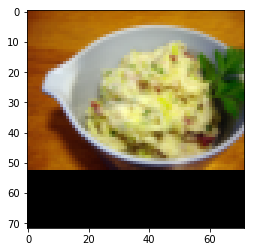

In [19]:
plt.imshow(arr_lr[10].astype('uint8'));

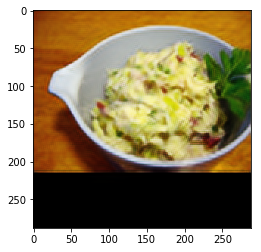

In [20]:
p = lr_model.predict(arr_lr[10:11])
plt.imshow(p[0].astype('uint8'));

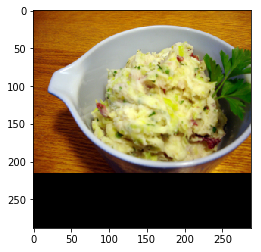

In [21]:
plt.imshow(arr_hr[10].astype('uint8'));

In [ ]:
hr_inp, hr_out = get_mo